# Alphamind新手入门之五：Alpha因子的五分位分析

In [1]:
import os

# %matplotlib inline
import os
import pandas as pd
import numpy as np
from matplotlib import rc
from matplotlib import pyplot as plt
from PyFin.api import makeSchedule
from alphamind.api import *
from alphamind.analysis.quantileanalysis import er_quantile_analysis

rc('font', **{'family': 'Microsoft YaHei', 'size': 10})
rc('mathtext', **{'default': 'regular'})
rc('legend', **{'frameon': False})

## 1. 数据准备
------------------

* 股票池：中证800
* 因子：`ETOP`
* 调仓频率：5个交易日
* 起始日：2010年1月1日
* 终止日：2019年1月31日
* 分位数：5

In [5]:
engine = SqlEngine(os.environ['DB_URI'])
universe = Universe('zz800')   # 股票池设置，此处设置为中证800，可选中证500（zz500）和沪深300（hs300）
factor = 'EMA5D'   #"ROE" 因子
freq = '5b' #调仓频率 5个工作日“5b”
start_date = '2020-01-01'  # 回测起始日
end_date = '2021-01-31'    # 回测终止日
n_bins = 5    # 分组数
# 因子中性化设置 
# industry_stryles为行业风格   risk_styles 为风险风格   
neutralized_styles = industry_styles # risk_styles + industry_styles  
# makeSchedule函数 用于设置调仓日的生成工作日序列
dates = makeSchedule(start_date, end_date, freq, 'china.sse') 
horizon = map_freq(freq) # 对于调仓频率的数值化过程

In [6]:
%%time

#获取数据
#fetch_factor_range 获取因子数据
#fetch_risk_model_range 获取风险模型数据
#fetch_dx_return_range 获取收益率数据

#%%time
factor_data = engine.fetch_factor_range(universe, factor, dates=dates)
risk_cov, risk_factors = engine.fetch_risk_model_range(universe, dates=dates)
return_data = engine.fetch_dx_return_range(universe, dates=dates, horizon=horizon)
total_data = pd.merge(factor_data, risk_factors, on=['trade_date', 'code'])
total_data = pd.merge(total_data, return_data, on=['trade_date', 'code']).dropna()

CPU times: user 3.79 s, sys: 269 ms, total: 4.06 s
Wall time: 41.9 s


## 2. 分位数群组收益比较
-----------------------

In [7]:
#neutralize 因子中性化函数

neutralized_factors = neutralize(total_data[neutralized_styles].values.astype(float),
                                 total_data[factor].values,
                                 groups=total_data['trade_date'].values)
total_data['neutralized_factors'] = neutralized_factors

In [8]:
%%time
# er_quantile_analysis 分位数分析函数

df = pd.DataFrame(columns=['q' + str(i) for i in range(1, n_bins+1)])

grouped = total_data.groupby('trade_date')
for k, g in grouped:
    er = g['neutralized_factors'].values
    dx_return = g['dx'].values
    res = er_quantile_analysis(er, n_bins=n_bins, dx_return=dx_return, de_trend=True)
    df.loc[k, :] = res

CPU times: user 155 ms, sys: 73.2 ms, total: 228 ms
Wall time: 57 ms


<AxesSubplot:>

findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans.


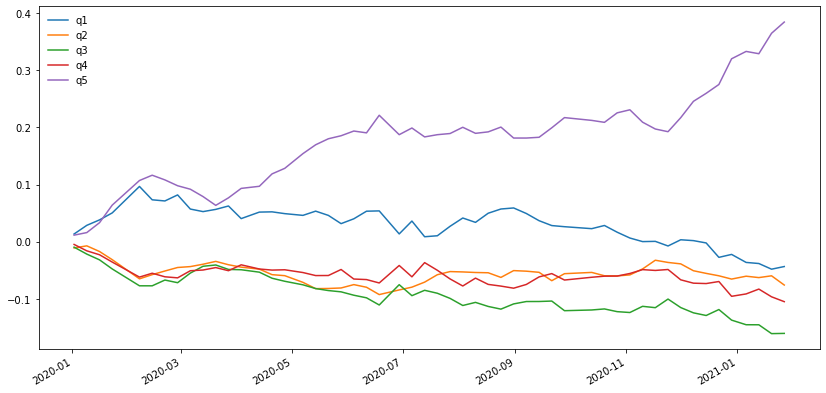

In [9]:
df.cumsum().plot(figsize=(14, 7))

<AxesSubplot:>

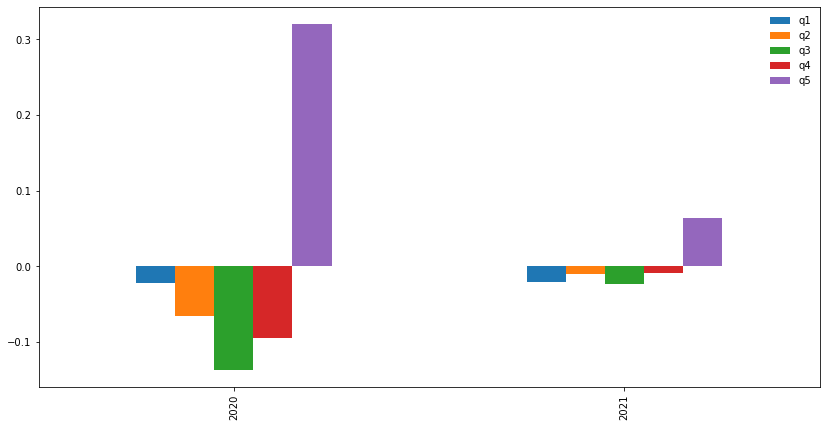

In [10]:
ret_yearly = df.groupby(df.index.year).sum()
ret_yearly.plot(kind='bar', figsize=(14, 7))

<AxesSubplot:>

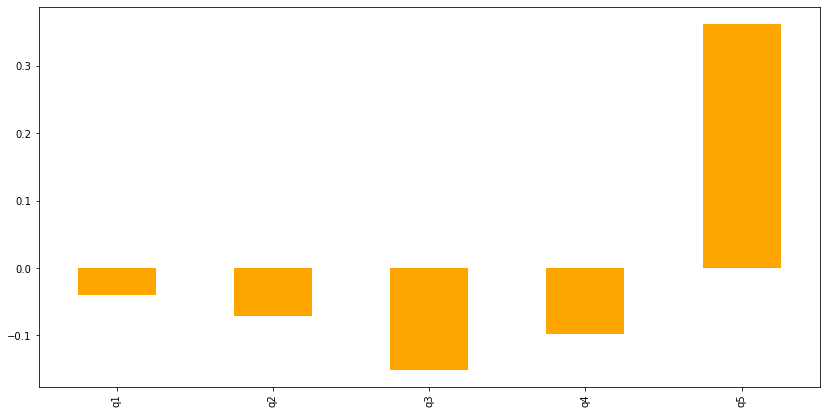

In [11]:
(df.mean() * 50).plot(kind='bar', figsize=(14, 7), color='orange')